In [1]:
import pandas as pd
import json
import seaborn as sns
import operator

### Подготовка списка фильмов с ключевыми словами

##### Подготовка датафрейма с метаданными фильмов (без ключевых слов)

In [2]:
# загрузка исходного датафрейма с метаданными фильмов, удаление пустых и ложных записей, удаление дупликатов, приведение к типам

df_meta = pd.read_csv('./moviesdataset/movies_metadata.csv',low_memory=False)
df_meta = df_meta.loc[:,['title','id','imdb_id']]


df_meta = df_meta.dropna(subset='imdb_id')
df_meta = df_meta.drop_duplicates(subset='imdb_id')
df_meta = df_meta.drop_duplicates(subset='id')
df_meta = df_meta.drop(df_meta[df_meta['id'].str.contains('-')].index)

df_meta = df_meta.astype({'title': 'string', 'id': 'int32','imdb_id': 'string'})
df_meta = df_meta.set_index('id')

df_meta.dtypes
df_meta.shape

(45416, 2)

##### Подготовка датафрейма с ключевыми словами

In [3]:
# загрузка исходного датафрейма с ключевыми словами, приведение к типам

df_kw = pd.read_csv('./moviesdataset/keywords.csv')
df_kw = df_kw.astype({'id': 'int32','keywords': 'string'})
df_kw = df_kw.drop_duplicates(subset='id')

df_kw = df_kw.set_index('id')
df_kw

,keywords
id,
862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...
439050,"[{'id': 10703, 'name': 'tragic love'}]"
111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
67758,[]


In [4]:
# обращение ключевых слов dict -> list для удобства работы, подчёт кол-ва ключевых слов в каждом фильме

def get_kw_list(data):
    kw_list = ','.join([kw['name'] for kw in eval(data)])
    return kw_list

df_kw.loc[:,'keylist'] = df_kw['keywords'].apply(get_kw_list)
df_kw['keywords_len'] = df_kw['keylist'].apply(lambda x: len(str.split(x, sep=',')))
# df_kw = df_kw.drop(['keywords'],axis=1)
# df_kw.iloc[0,:]['keylist']
# df_kw = df_kw.iloc[:,:][df_kw['keywords_len'] >= 15]
df_kw

,keywords,keylist,keywords_len
id,,,
862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","jealousy,toy,boy,friendship,friends,rivalry,bo...",9
8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","board game,disappearance,based on children's b...",6
15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","fishing,best friend,duringcreditsstinger,old men",4
31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","based on novel,interracial relationship,single...",5
11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby,midlife crisis,confidence,aging,daughter,...",9
...,...,...,...
439050,"[{'id': 10703, 'name': 'tragic love'}]",tragic love,1
111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","artist,play,pinoy",3
67758,[],,1


In [5]:
# подготовка частотного словаря ключевых слов
def get_kw_counts(column):

    kw_series = pd.Series(str.split(column.str.cat(sep=','), sep=','))
    kw_count = kw_series.value_counts()

    counts = pd.DataFrame({'kw':kw_count.index,'count': kw_count})

    counts = counts.drop_duplicates(subset='kw')
    counts = counts.sort_values(by=['count','kw'], ascending=[False, True])

    kw_quantity = len(counts)
    will_deleted = len(counts[counts['count']==1])

    print(f'Ключевых слов, встречающихся однажды: {will_deleted} ({round(will_deleted/kw_quantity*100,3)}%)')

    return counts

In [6]:
def print_kw_stat(column):
    column = df_kw['keylist_nolonely']
    counts = get_kw_counts(column)
    counts['wordsq'] = counts['kw'].apply(lambda x: len(x.split()))
    most_popular_count = counts.iloc[0,:]['count']
    most_popular_kw = counts.iloc[0,:]['kw']
    most_rare_count = counts.iloc[-1,:]['count']
    most_rare_kw = counts.iloc[-1,:]['kw']
    print(f'Самое популярное слово: {most_popular_kw}, {most_popular_count} раз')
    print(f'Самое редкое слово: {most_rare_kw}, {most_rare_count} раз')
    print(f'Всего слов: {len(counts)}')
    print(f'Среднее кол-во слов в ключевых словах: {round(counts.wordsq.mean(),4)}')

Ключевых слов, встречающихся однажды: 8694 (43.546%)


<Axes: xlabel='wordsq', ylabel='Count'>

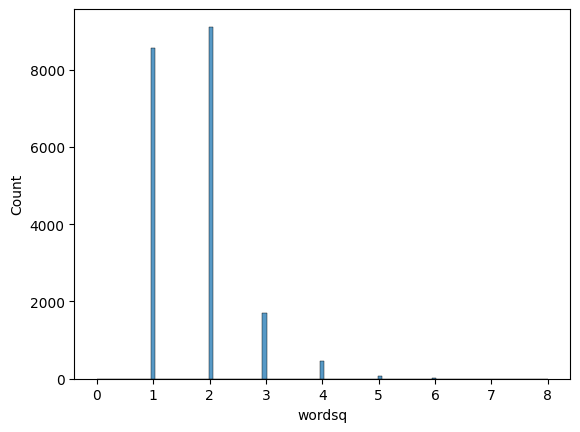

In [7]:
# подсчёт слов в отдельных ключевых словах (для информации)

counts = get_kw_counts(df_kw['keylist'])

counts['wordsq'] = counts['kw'].apply(lambda x: len(x.split()))
sns.histplot(data=counts['wordsq'])

In [8]:
# преобразование многосложных ключевых слов к односложным (удалением пробелов)

def kw_del_space(keylist):

    kw_cleaned = []

    for kw in keylist.split(sep=','):
        if len(kw.split(sep=' ')) > 1:
            kw_cleaned.append(kw.replace(' ','').replace(u'\xa0',u''))
        elif len(kw.split(sep='\xa0')) > 1:
            kw_cleaned.append(kw.replace(' ','').replace(u'\xa0',u''))
        else:
            kw_cleaned.append(kw)

    return ','.join(kw_cleaned)

df_kw['keylist_nospace'] = df_kw['keylist'].apply(kw_del_space)
df_kw

,keywords,keylist,keywords_len,keylist_nospace
id,,,,
862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","jealousy,toy,boy,friendship,friends,rivalry,bo...",9,"jealousy,toy,boy,friendship,friends,rivalry,bo..."
8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","board game,disappearance,based on children's b...",6,"boardgame,disappearance,basedonchildren'sbook,..."
15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","fishing,best friend,duringcreditsstinger,old men",4,"fishing,bestfriend,duringcreditsstinger,oldmen"
31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","based on novel,interracial relationship,single...",5,"basedonnovel,interracialrelationship,singlemot..."
11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby,midlife crisis,confidence,aging,daughter,...",9,"baby,midlifecrisis,confidence,aging,daughter,m..."
...,...,...,...,...
439050,"[{'id': 10703, 'name': 'tragic love'}]",tragic love,1,tragiclove
111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","artist,play,pinoy",3,"artist,play,pinoy"
67758,[],,1,


In [9]:
# удаление строк без ключевых слов

df_kw = df_kw[df_kw['keylist'] != '']
df_kw

,keywords,keylist,keywords_len,keylist_nospace
id,,,,
862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","jealousy,toy,boy,friendship,friends,rivalry,bo...",9,"jealousy,toy,boy,friendship,friends,rivalry,bo..."
8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","board game,disappearance,based on children's b...",6,"boardgame,disappearance,basedonchildren'sbook,..."
15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","fishing,best friend,duringcreditsstinger,old men",4,"fishing,bestfriend,duringcreditsstinger,oldmen"
31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","based on novel,interracial relationship,single...",5,"basedonnovel,interracialrelationship,singlemot..."
11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby,midlife crisis,confidence,aging,daughter,...",9,"baby,midlifecrisis,confidence,aging,daughter,m..."
...,...,...,...,...
84419,"[{'id': 9748, 'name': 'revenge'}, {'id': 9826,...","revenge,murder,serial killer,new york city,scu...",7,"revenge,murder,serialkiller,newyorkcity,sculpt..."
390959,"[{'id': 224180, 'name': 'blair witch'}]",blair witch,1,blairwitch
289923,"[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n...","witch,mythology,legend,serial killer,mockumentary",5,"witch,mythology,legend,serialkiller,mockumentary"


In [10]:
# удаление тех ключевых слов, которые встречаются только однажды

counts = get_kw_counts(df_kw['keylist_nospace'])
onlyonemeet = counts[counts['count'] == 1]['kw']

def kw_del_onlyonemeet(keylist):

    kw_cleaned = []
    kw_list = keylist.split(sep=',')

    for index, kw in enumerate(kw_list):
        if kw in onlyonemeet:
            pass
        else:
            kw_cleaned.append(kw)
    
    return ','.join(kw_cleaned)

df = df_kw.copy(deep=True)
df['keylist_nolonely'] = df_kw['keylist_nospace'].apply(kw_del_onlyonemeet)
counts = get_kw_counts(df['keylist_nolonely'])

Ключевых слов, встречающихся однажды: 8613 (43.432%)
Ключевых слов, встречающихся однажды: 0 (0.0%)


In [11]:
# отбор не более 15 ключевых слов (удалением наиболее редких)

counts = get_kw_counts(df['keylist_nolonely'])
quantity = 15

def get_most_common(keylist):

    kw_list = keylist.split(sep=',')

    if len(kw_list) > quantity:

        kw_cleaned = {}

        for kw in kw_list:
            kw_cleaned[kw] = counts[counts['kw'] == kw]['count'].values[0]

        most_common = [kw[0] for kw in sorted(kw_cleaned.items(), key=operator.itemgetter(1), reverse=True)[:quantity]]
        
        return ','.join(most_common)

    else:
        return keylist   

df['keylist_fifteen'] = df['keylist_nolonely'].apply(get_most_common)
df['keywords_len_commons'] = df['keylist_fifteen'].apply(lambda x: len(str.split(x, sep=',')))
df

Ключевых слов, встречающихся однажды: 0 (0.0%)


,keywords,keylist,keywords_len,keylist_nospace,keylist_nolonely,keylist_fifteen,keywords_len_commons
id,,,,,,,
862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","jealousy,toy,boy,friendship,friends,rivalry,bo...",9,"jealousy,toy,boy,friendship,friends,rivalry,bo...","jealousy,toy,boy,friendship,friends,rivalry,bo...","jealousy,toy,boy,friendship,friends,rivalry,bo...",9
8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","board game,disappearance,based on children's b...",6,"boardgame,disappearance,basedonchildren'sbook,...","boardgame,disappearance,basedonchildren'sbook,...","boardgame,disappearance,basedonchildren'sbook,...",6
15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","fishing,best friend,duringcreditsstinger,old men",4,"fishing,bestfriend,duringcreditsstinger,oldmen","fishing,bestfriend,duringcreditsstinger,oldmen","fishing,bestfriend,duringcreditsstinger,oldmen",4
31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","based on novel,interracial relationship,single...",5,"basedonnovel,interracialrelationship,singlemot...","basedonnovel,interracialrelationship,singlemot...","basedonnovel,interracialrelationship,singlemot...",5
11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby,midlife crisis,confidence,aging,daughter,...",9,"baby,midlifecrisis,confidence,aging,daughter,m...","baby,midlifecrisis,confidence,aging,daughter,m...","baby,midlifecrisis,confidence,aging,daughter,m...",9
...,...,...,...,...,...,...,...
84419,"[{'id': 9748, 'name': 'revenge'}, {'id': 9826,...","revenge,murder,serial killer,new york city,scu...",7,"revenge,murder,serialkiller,newyorkcity,sculpt...","revenge,murder,serialkiller,newyorkcity,sculpt...","revenge,murder,serialkiller,newyorkcity,sculpt...",7
390959,"[{'id': 224180, 'name': 'blair witch'}]",blair witch,1,blairwitch,blairwitch,blairwitch,1
289923,"[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n...","witch,mythology,legend,serial killer,mockumentary",5,"witch,mythology,legend,serialkiller,mockumentary","witch,mythology,legend,serialkiller,mockumentary","witch,mythology,legend,serialkiller,mockumentary",5


In [12]:
# отбор не менее 15 слов 

df = df[df['keywords_len_commons'] == 15]

In [13]:
# объединение с датасетом с метаданными (для получения названий)
df_joined = df.join(df_meta, on='id')
df_joined.loc[:,['keylist_fifteen','title','imdb_id']]

,keylist_fifteen,title,imdb_id
id,,,
949,"murder,suspense,detective,robbery,money,gang,o...",Heat,tt0113277
710,"cuba,falselyaccused,secretidentity,computervir...",GoldenEye,tt0113189
8012,"murder,basedonnovel,violence,drug,gangster,mon...",Get Shorty,tt0113161
9691,"hitman,rescue,shootout,competition,cia,cat,ass...",Assassins,tt0112401
451,"prostitute,losangeles,dyinganddeath,alcohol,al...",Leaving Las Vegas,tt0113627
...,...,...,...
27066,"basedonnovel,sex,nudity,femalenudity,malenudit...",The Voyeur,tt0111573
383526,"gay,lgbt,homosexuality,gayinterest,gayrelation...",You'll Never Be Alone,tt4846220
410118,"murder,sex,nudity,suspense,femalenudity,lovetr...",Cave,tt4915318


In [20]:
df_sub_skip = pd.read_csv('fil_sub_download_temp_file.csv', sep=';', names=['imdb_id','moviename', 'data','file'])
df_sub_skip = df_sub_skip.astype({'imdb_id': 'int32','moviename': 'string','data': 'object','file': 'object'})
df_sub_skip = df_sub_skip.drop_duplicates(subset='imdb_id')
df_sub_skip = df_sub_skip.drop(df_sub_skip[df_sub_skip['moviename'] == 'ERROR'].index)
df_sub_skip

,imdb_id,moviename,data,file
0,76759,Star Wars: Episode IV - A New Hope,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1951740969': '/home/eva/Diploma/os/0076759.s...
1,109830,Forrest Gump,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1952039423': '/home/eva/Diploma/os/0109830.s...
2,169547,American Beauty,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1953328037': '/home/eva/Diploma/os/0169547.s...
3,168629,Dancer in the Dark,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1953190010': '/home/eva/Diploma/os/0168629.s...
4,119116,The Fifth Element,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1952183249': '/home/eva/Diploma/os/0119116.s...
...,...,...,...,...
1224,1529572,Trust,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1953147055': '/home/eva/Diploma/os/1529572.s...
1225,67224,The Hunting Party,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'245649': '/home/eva/Diploma/os/67224.srt'}
1226,1512235,Super,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1952897994': '/home/eva/Diploma/os/1512235.s...
1227,85250,Women's Prison Massacre,"{'MatchedBy': 'imdbid', 'IDSubMovieFile': '0',...",{'1955047837': '/home/eva/Diploma/os/85250.srt'}


In [22]:
df_doned = df_sub_skip.join(df_joined, on='imdb_id', how='left')
df_doned

ValueError: columns overlap but no suffix specified: Index(['imdb_id'], dtype='object')